In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms 
import sklearn as sk

from patsy import dmatrix

import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

import platform
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)

import warnings
warnings.filterwarnings("ignore")

/Users/sunwoongkim/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
train = pd.read_csv("../dataset/train.csv", parse_dates=["pickup_datetime", "dropoff_datetime"])
print("Shape of Train Data: ", train.shape)

Shape of Train Data:  (1458644, 11)


In [3]:
train["pickup_month"] = train["pickup_datetime"].dt.month
train["pickup_weekday"] = train["pickup_datetime"].dt.weekday
train["pickup_hour"] = train["pickup_datetime"].dt.hour

In [4]:
working_day = [0, 1, 2, 3, 4] # Mon-Fri
train["working_day"] = train["pickup_weekday"].isin(working_day).astype(int)

In [5]:
train["store_and_fwd_flag"] = 1 * (train.store_and_fwd_flag.values == 'Y')

In [6]:
lat1, lng1, lat2, lng2 = (train['pickup_latitude'].values, train['pickup_longitude'].values, 
                          train['dropoff_latitude'].values, train['dropoff_longitude'].values)

In [7]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [8]:
def bearing_array(lat1, lng1, lat2, lng2):
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return (np.degrees(np.arctan2(y, x)) + 360) % 360 # from -180/180 to 0/360

In [9]:
train = train.assign(distance = haversine_array(lat1, lng1, lat2, lng2))
train = train.assign(bearing = bearing_array(lat1, lng1, lat2, lng2))

In [10]:
X_cols = [col for col in train.columns if col != "trip_duration"]
train_X0 = train[X_cols]
train_y = train[["trip_duration"]]

In [11]:
col_real = ["passenger_count", "distance", "bearing", "pickup_longitude", 
            "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]

col_cats = [col for col in train.columns if col not in col_real]
for col in ["pickup_datetime", "dropoff_datetime", "id"]:
    col_cats.remove(col)
col_cats_nontime = ["vendor_id", "store_and_fwd_flag", "working_day"]

In [12]:
model = sm.OLS.from_formula("trip_duration ~ passenger_count + distance + bearing + pickup_month +" 
                            "pickup_weekday + pickup_hour + pickup_latitude + pickup_longitude +"
                            "dropoff_latitude + dropoff_longitude + C(vendor_id) + C(store_and_fwd_flag)"
                            "+ C(working_day)", train)
result_01 = model.fit()
print(result_01.summary())

KeyboardInterrupt: 

In [12]:
train = train[train["trip_duration"]<1500000]

In [ ]:
model = sm.OLS.from_formula("scale(trip_duration) ~ passenger_count + distance + bearing + pickup_month +" 
                            "pickup_weekday + pickup_hour + pickup_latitude + pickup_longitude +"
                            "dropoff_latitude + dropoff_longitude + C(vendor_id) + C(store_and_fwd_flag)"
                            "+ C(working_day)", train)
result_01 = model.fit()
print(result_01.summary())

In [ ]:
model = sm.OLS.from_formula("scale(trip_duration) ~ scale(distance) + bearing + pickup_month +" 
                            "pickup_weekday + pickup_hour + pickup_latitude + pickup_longitude +"
                            "dropoff_latitude + dropoff_longitude + C(vendor_id) + C(store_and_fwd_flag)"
                            "+ C(working_day)", train)
result_01 = model.fit()
print(result_01.summary())

In [ ]:
model = sm.OLS.from_formula("scale(trip_duration) ~ scale(distance) + bearing + pickup_month +" 
                            "pickup_weekday + pickup_hour + scale(pickup_latitude) + scale(pickup_longitude) +"
                            "scale(dropoff_latitude) + scale(dropoff_longitude) + C(vendor_id) + C(store_and_fwd_flag)"
                            "+ C(working_day)", train)
result_01 = model.fit()
print(result_01.summary())

In [13]:
weird_p = train.loc[(train["pickup_latitude"]>45) | (train["pickup_longitude"]<-100)]
weird_d = train.loc[(train["dropoff_latitude"]<36) | (train["dropoff_longitude"]<-120)]

In [14]:
train = train[train["pickup_latitude"] < 45]
train = train[train["pickup_longitude"] > -100]
train = train[train["dropoff_latitude"] > 36]
train = train[train["dropoff_latitude"] > -120]

In [ ]:
# model = sm.OLS.from_formula("scale(np.log1p(trip_duration)) ~ scale(np.log1p(distance)) + scale(bearing) + pickup_month +" 
#                             "scale(np.sin(pickup_weekday)) + scale(pickup_hour) + scale(pickup_longitude) +"
#                             "scale(dropoff_latitude) + scale(dropoff_longitude) + C(vendor_id)" , train)
# result_01 = model.fit()
# print(result_01.summary()) 0.582

In [ ]:
# model = sm.OLS.from_formula("scale(np.log1p(trip_duration)) ~ scale(np.log1p(distance)) + scale(bearing) + pickup_month +" 
#                             "scale(np.sin(pickup_weekday)) + scale(pickup_hour) + scale(pickup_longitude) +"
#                             "scale(dropoff_latitude) + scale(dropoff_longitude) + scale(vendor_id)" , train)
# result_01 = model.fit()
# print(result_01.summary()) 0.582

In [26]:
model = sm.OLS.from_formula("scale(np.log1p(trip_duration)) ~ scale(np.log1p(distance)) + scale(bearing) + pickup_month +" 
                            "scale(np.sin(pickup_weekday)) + scale(pickup_hour) + scale(pickup_longitude) +"
                            "scale(dropoff_latitude) + scale(dropoff_longitude) + C(vendor_id)" , train)
result_01 = model.fit()
print(result_01.summary())

                                  OLS Regression Results                                  
Dep. Variable:     scale(np.log1p(trip_duration))   R-squared:                       0.582
Model:                                        OLS   Adj. R-squared:                  0.582
Method:                             Least Squares   F-statistic:                 2.260e+05
Date:                            Wed, 14 Mar 2018   Prob (F-statistic):               0.00
Time:                                    04:19:11   Log-Likelihood:            -1.4330e+06
No. Observations:                         1458634   AIC:                         2.866e+06
Df Residuals:                             1458624   BIC:                         2.866e+06
Df Model:                                       9                                         
Covariance Type:                        nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025     

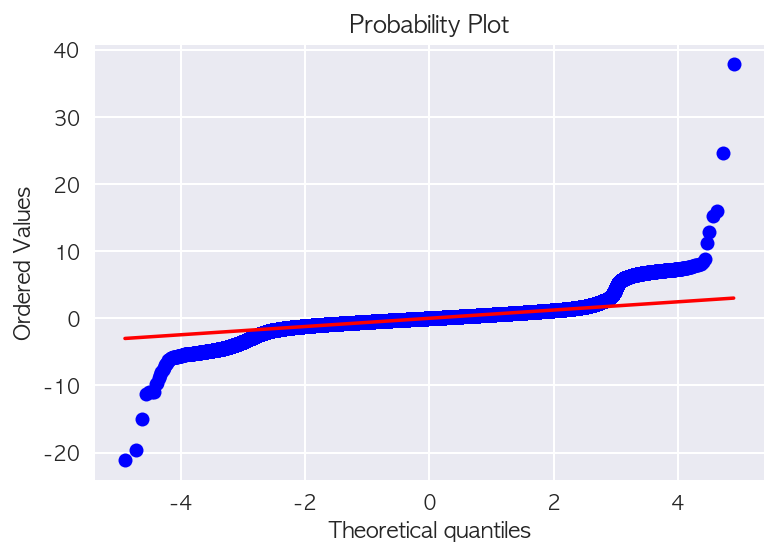

In [70]:
sp.stats.probplot(result_01.resid, plot=plt)
plt.show()

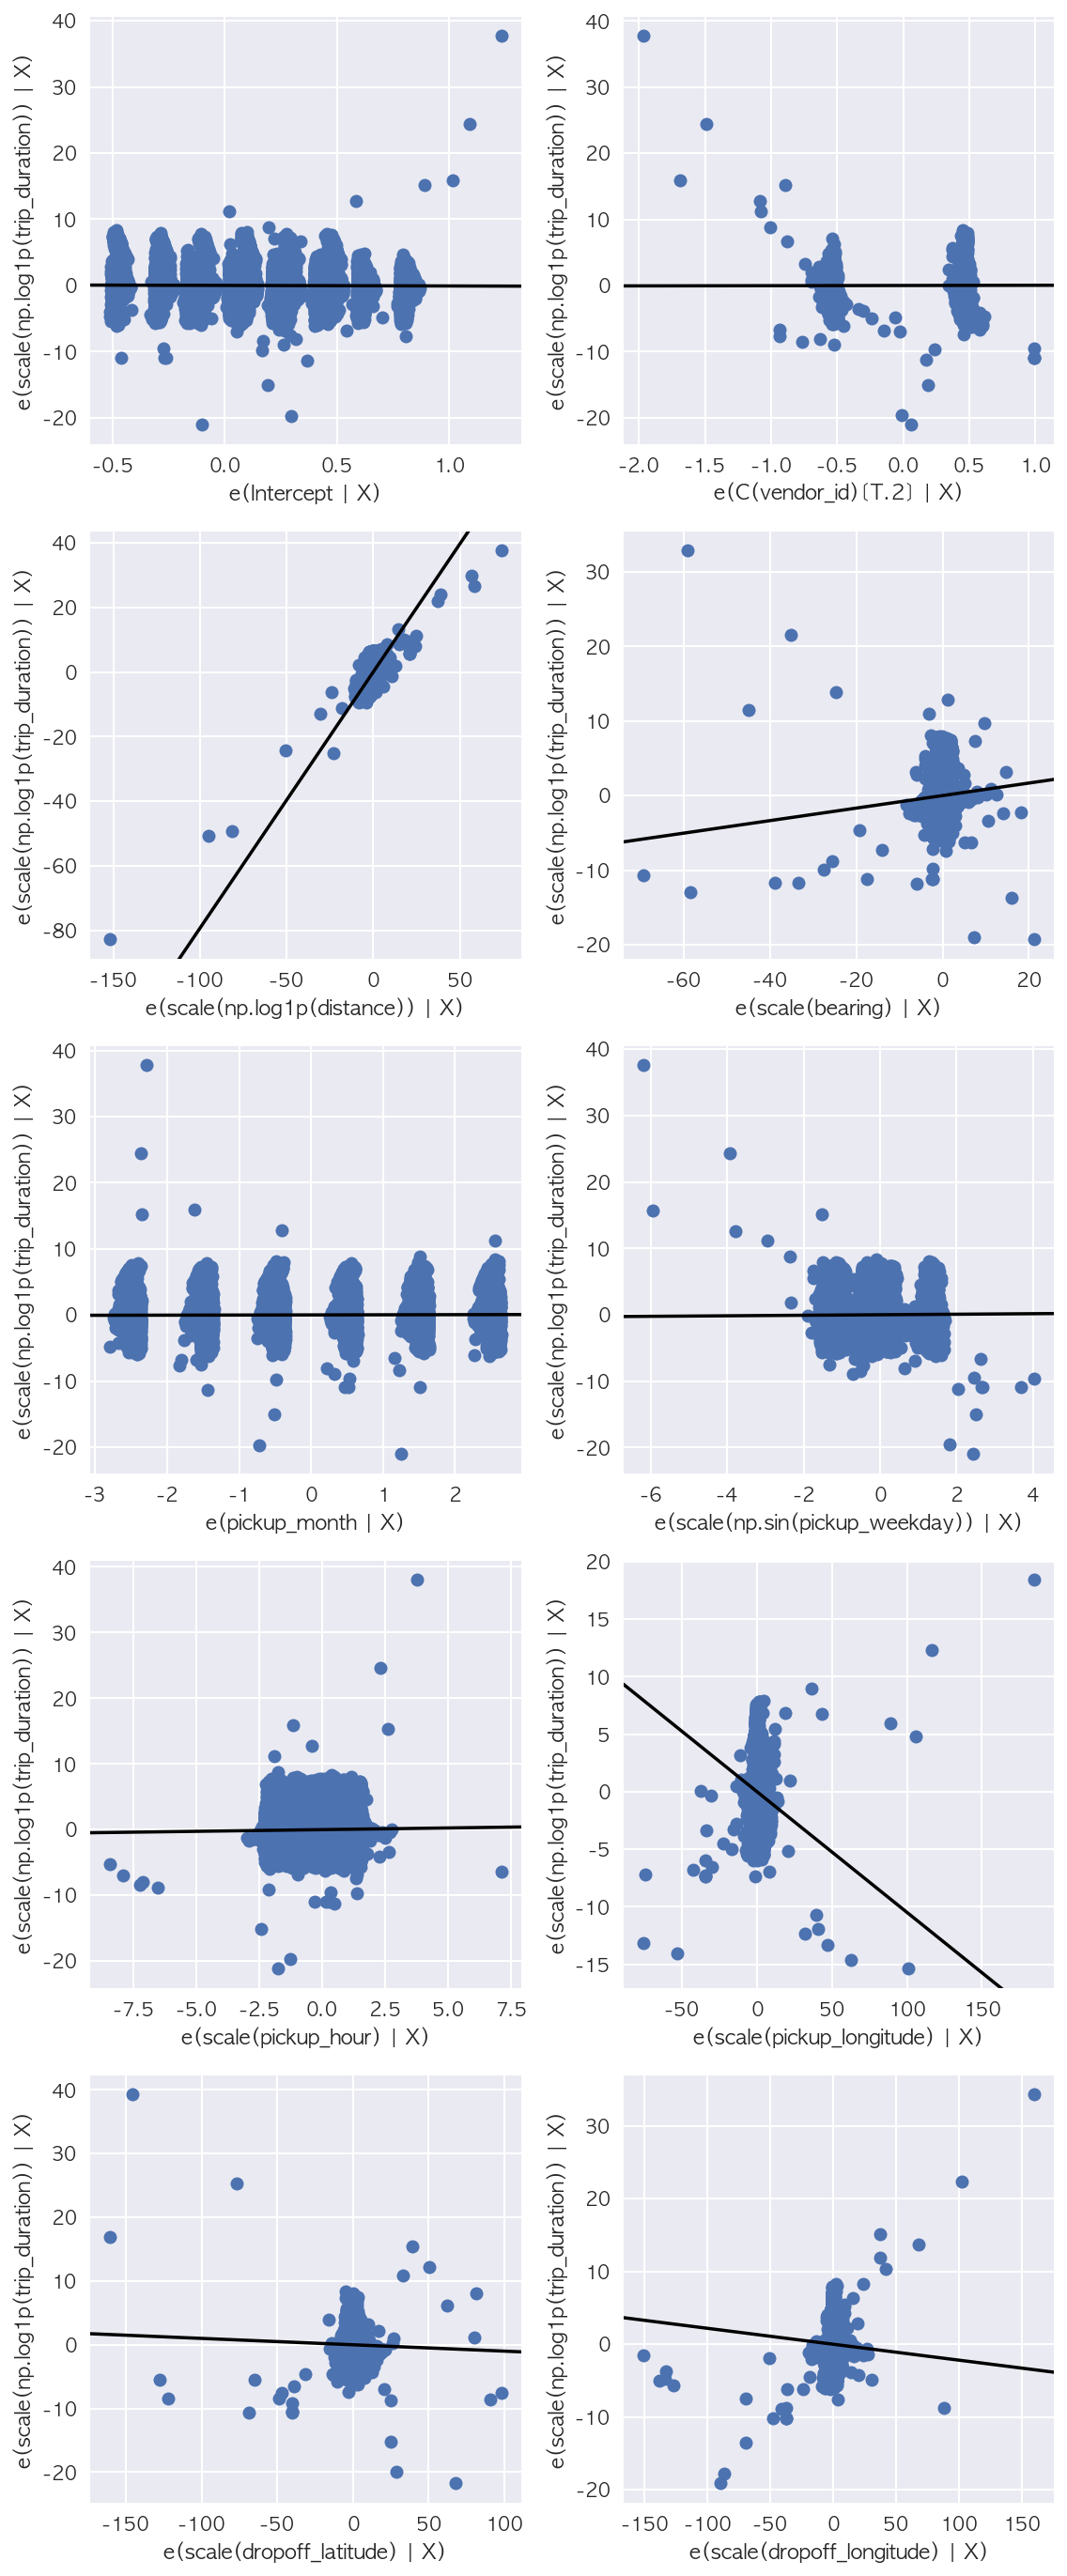

In [71]:
fig = plt.figure(figsize=(8,20))
sm.graphics.plot_partregress_grid(result_01, fig=fig)
fig.suptitle("")
plt.show()

In [27]:
influence = result_01.get_influence()
hat = influence.hat_matrix_diag

In [30]:
idx_hat = np.where(hat > 3*hat.mean())[0]

In [31]:
influence = result_01.get_influence()
cooks_d2, pvals = influence.cooks_distance
fox_cr = 4 / (len(train) - 10)
idx_cooks = np.where(cooks_d2 > fox_cr)[0]

In [32]:
idx_rp = np.where(result_01.resid_pearson > 2)[0]
len(idx_rp)

23296

In [38]:
model = sm.OLS.from_formula("scale(np.log1p(trip_duration)) ~ scale(np.log1p(distance)) + scale(bearing) + scale(pickup_month) +" 
                            "scale(pickup_weekday) + scale(pickup_hour) + scale(pickup_longitude) +"
                            "scale(dropoff_latitude) + scale(dropoff_longitude) + C(vendor_id)" , train)
result_test = model.fit()
print(result_test.summary())

                                  OLS Regression Results                                  
Dep. Variable:     scale(np.log1p(trip_duration))   R-squared:                       0.582
Model:                                        OLS   Adj. R-squared:                  0.582
Method:                             Least Squares   F-statistic:                 2.261e+05
Date:                            Wed, 14 Mar 2018   Prob (F-statistic):               0.00
Time:                                    04:28:56   Log-Likelihood:            -1.4328e+06
No. Observations:                         1458634   AIC:                         2.866e+06
Df Residuals:                             1458624   BIC:                         2.866e+06
Df Model:                                       9                                         
Covariance Type:                        nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.9

### 1. 표준화잔차 2 이상 제거

In [37]:
train_rp = train.drop(idx_rp)
train_rp.reset_index(drop=True, inplace=True)
len(train_rp), len(train)

(1435338, 1458634)

In [39]:
model = sm.OLS.from_formula("scale(np.log1p(trip_duration)) ~ scale(np.log1p(distance)) + scale(bearing) + scale(pickup_month) +" 
                            "scale(pickup_weekday) + scale(pickup_hour) + scale(pickup_longitude) +"
                            "scale(dropoff_latitude) + scale(dropoff_longitude) + C(vendor_id)" , train_rp)
result_0201 = model.fit()
print(result_0201.summary())

                                  OLS Regression Results                                  
Dep. Variable:     scale(np.log1p(trip_duration))   R-squared:                       0.591
Model:                                        OLS   Adj. R-squared:                  0.591
Method:                             Least Squares   F-statistic:                 2.308e+05
Date:                            Wed, 14 Mar 2018   Prob (F-statistic):               0.00
Time:                                    04:31:38   Log-Likelihood:            -1.3944e+06
No. Observations:                         1435338   AIC:                         2.789e+06
Df Residuals:                             1435328   BIC:                         2.789e+06
Df Model:                                       9                                         
Covariance Type:                        nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.9

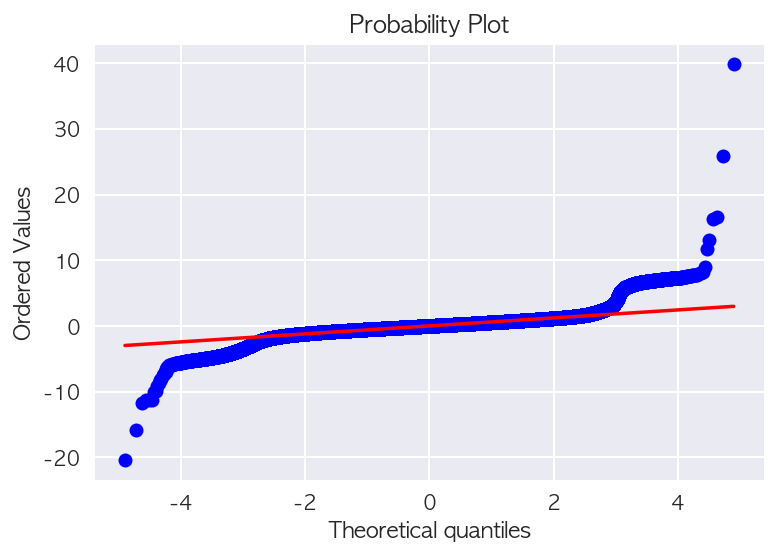

In [46]:
sp.stats.probplot(result_0201.resid, plot=plt)
plt.show()

### 2. 평균 레버리지 3배 이상 제거

In [41]:
model = sm.OLS.from_formula("scale(np.log1p(trip_duration)) ~ scale(np.log1p(distance)) + scale(bearing) + scale(pickup_month) +" 
                            "scale(pickup_weekday) + scale(pickup_hour) + scale(pickup_longitude) +"
                            "scale(dropoff_latitude) + scale(dropoff_longitude) + C(vendor_id)" , train_lvr)
result_0202 = model.fit()
print(result_0202.summary())

                                  OLS Regression Results                                  
Dep. Variable:     scale(np.log1p(trip_duration))   R-squared:                       0.579
Model:                                        OLS   Adj. R-squared:                  0.579
Method:                             Least Squares   F-statistic:                 2.156e+05
Date:                            Wed, 14 Mar 2018   Prob (F-statistic):               0.00
Time:                                    04:42:13   Log-Likelihood:            -1.3910e+06
No. Observations:                         1410325   AIC:                         2.782e+06
Df Residuals:                             1410315   BIC:                         2.782e+06
Df Model:                                       9                                         
Covariance Type:                        nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.9

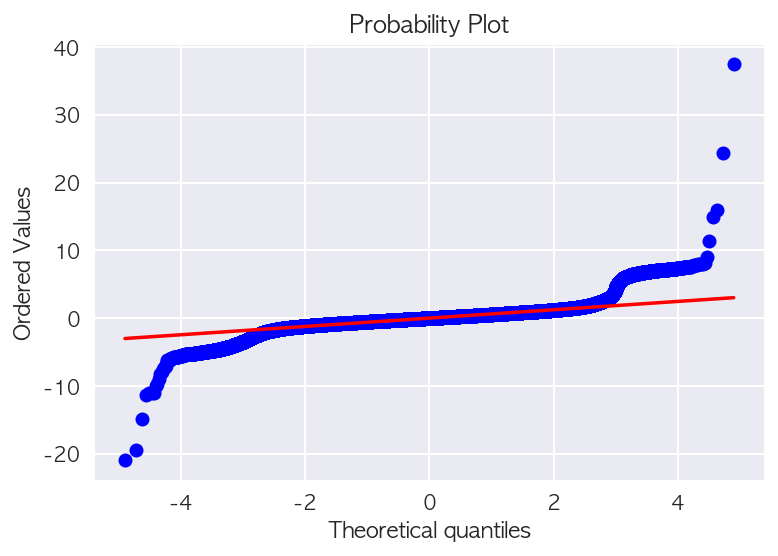

In [45]:
sp.stats.probplot(result_0202.resid, plot=plt)
plt.show()

### 3. cooks_dist 4 이상 제거

In [42]:
train_cooks = train.drop(idx_cooks)
train_cooks.reset_index(drop=True, inplace=True)
len(train_cooks), len(train)

(1407730, 1458634)

In [43]:
model = sm.OLS.from_formula("scale(np.log1p(trip_duration)) ~ scale(np.log1p(distance)) + scale(bearing) + scale(pickup_month) +" 
                            "scale(pickup_weekday) + scale(pickup_hour) + scale(pickup_longitude) +"
                            "scale(dropoff_latitude) + scale(dropoff_longitude) + C(vendor_id)" , train_cooks)
result_0203 = model.fit()
print(result_0203.summary())

                                  OLS Regression Results                                  
Dep. Variable:     scale(np.log1p(trip_duration))   R-squared:                       0.591
Model:                                        OLS   Adj. R-squared:                  0.591
Method:                             Least Squares   F-statistic:                 2.262e+05
Date:                            Wed, 14 Mar 2018   Prob (F-statistic):               0.00
Time:                                    04:44:52   Log-Likelihood:            -1.3679e+06
No. Observations:                         1407730   AIC:                         2.736e+06
Df Residuals:                             1407720   BIC:                         2.736e+06
Df Model:                                       9                                         
Covariance Type:                        nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.9

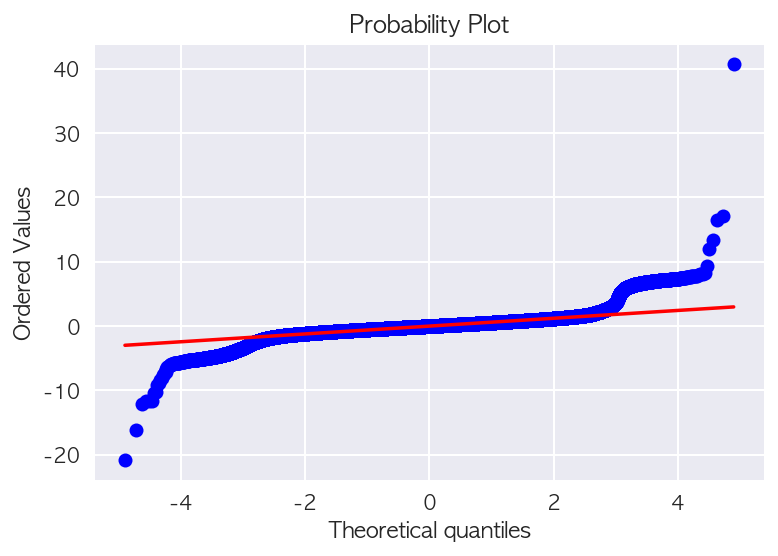

In [44]:
sp.stats.probplot(result_0203.resid, plot=plt)
plt.show()

In [52]:
model = sm.OLS.from_formula("scale(np.log1p(trip_duration)) ~ scale(np.log1p(distance)) + scale(bearing) + scale(pickup_month) +" 
                            "scale(pickup_weekday) + scale(pickup_hour) + scale(pickup_longitude) +"
                            "scale(dropoff_longitude) + C(vendor_id)" , train_cooks)
result_03 = model.fit()
print(result_03.summary())

                                  OLS Regression Results                                  
Dep. Variable:     scale(np.log1p(trip_duration))   R-squared:                       0.591
Model:                                        OLS   Adj. R-squared:                  0.591
Method:                             Least Squares   F-statistic:                 2.544e+05
Date:                            Wed, 14 Mar 2018   Prob (F-statistic):               0.00
Time:                                    04:58:25   Log-Likelihood:            -1.3680e+06
No. Observations:                         1407730   AIC:                         2.736e+06
Df Residuals:                             1407721   BIC:                         2.736e+06
Df Model:                                       8                                         
Covariance Type:                        nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.9

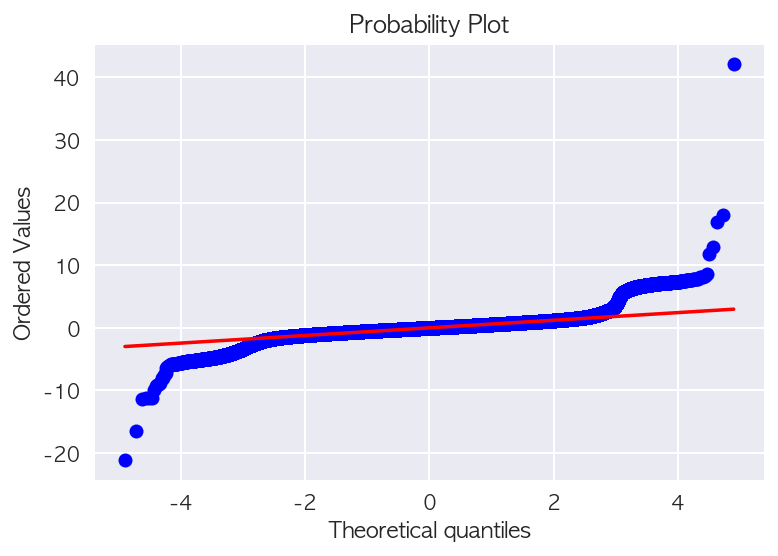

In [53]:
sp.stats.probplot(result_03.resid, plot=plt)
plt.show()

1895

In [ ]:
influence = result_01.get_influence()
cooks_d2, pvals = influence.cooks_distance
fox_cr = 4 / (len(train) - 10)

idx_cooks = np.where(cooks_d2 > fox_cr)[0]
train_cooks = train.drop(idx_cooks)
train_cooks.reset_index(drop=True, inplace=True)
len(train_cooks), len(train)

In [ ]:
model = sm.OLS.from_formula("np.log1p(trip_duration) ~ np.log1p(distance) + scale(pickup_month)" 
                            "scale(pickup_hour) + scale(I(pickup_hour**2)) + scale(pickup_weekday) +"
                            "scale(dropoff_latitude) + working_day", train_out_01)
result_07 = model.fit()
print(result_07.summary())

In [15]:
train = train[train["trip_duration"]<80000]

In [66]:
train_cooks = train_cooks[train_cooks["trip_duration"]<80000]

In [16]:
model = sm.OLS.from_formula("scale(np.log1p(trip_duration)) ~ scale(np.log1p(distance)) + scale(bearing) + scale(pickup_month) +" 
                            "scale(pickup_weekday) + scale(pickup_hour) + scale(pickup_longitude) +"
                            "scale(dropoff_longitude) + C(vendor_id)" , train)
result_04 = model.fit()
print(result_04.summary())

                                  OLS Regression Results                                  
Dep. Variable:     scale(np.log1p(trip_duration))   R-squared:                       0.612
Model:                                        OLS   Adj. R-squared:                  0.612
Method:                             Least Squares   F-statistic:                 2.868e+05
Date:                            Wed, 14 Mar 2018   Prob (F-statistic):               0.00
Time:                                    13:19:38   Log-Likelihood:            -1.3781e+06
No. Observations:                         1456739   AIC:                         2.756e+06
Df Residuals:                             1456730   BIC:                         2.756e+06
Df Model:                                       8                                         
Covariance Type:                        nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.9

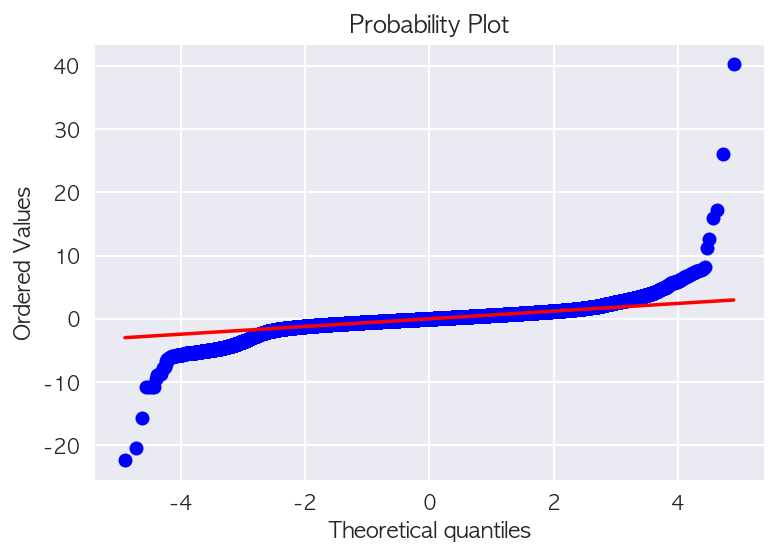

In [17]:
sp.stats.probplot(result_04.resid, plot=plt)
plt.show()

In [18]:
influence = result_04.get_influence()
cooks_d2, pvals = influence.cooks_distance
fox_cr = 4 / (len(train) - 9)

idx_cooks = np.where(cooks_d2 > fox_cr)[0]
# train_cooks = train.drop(idx_cooks)
# train_cooks.reset_index(drop=True, inplace=True)
# len(train_cooks), len(train)

In [22]:
train_out = train.copy()

In [23]:
train_out.reset_index(drop=True, inplace=True)
train_out = train_out.drop(idx_cooks)

In [24]:
train_out.reset_index(drop=True, inplace=True)

In [25]:
len(train_out)

1399052

In [26]:
model = sm.OLS.from_formula("scale(np.log1p(trip_duration)) ~ scale(np.log1p(distance)) + scale(bearing) + scale(pickup_month) +" 
                            "scale(pickup_weekday) + scale(I(pickup_weekday**2)) + scale(I(pickup_hour**4))+"
                            "scale(I(pickup_hour**2))+ scale(pickup_longitude) +"
                            "+ C(vendor_id)" , train_out)
result_04 = model.fit()
print(result_04.summary())

                                  OLS Regression Results                                  
Dep. Variable:     scale(np.log1p(trip_duration))   R-squared:                       0.700
Model:                                        OLS   Adj. R-squared:                  0.700
Method:                             Least Squares   F-statistic:                 3.634e+05
Date:                            Wed, 14 Mar 2018   Prob (F-statistic):               0.00
Time:                                    13:24:15   Log-Likelihood:            -1.1420e+06
No. Observations:                         1399052   AIC:                         2.284e+06
Df Residuals:                             1399042   BIC:                         2.284e+06
Df Model:                                       9                                         
Covariance Type:                        nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025     

((array([-4.89344086, -4.71600549, -4.62014397, ...,  4.62014397,
          4.71600549,  4.89344086]),
  array([-2.42385889, -2.33399891, -2.31563057, ...,  2.33402723,
          2.33920342,  2.39480568])),
 (0.54728701355664711, -4.4695224212652099e-16, 0.99988728177141262))

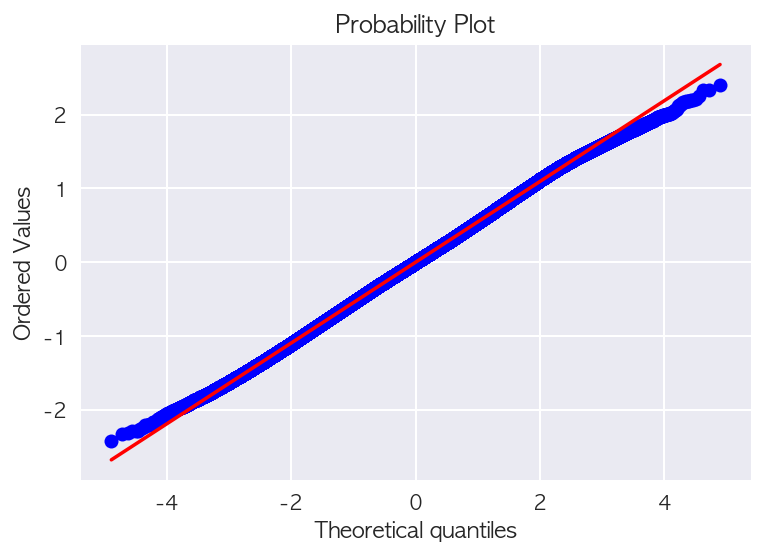

In [27]:
sp.stats.probplot(result_04.resid, plot=plt)

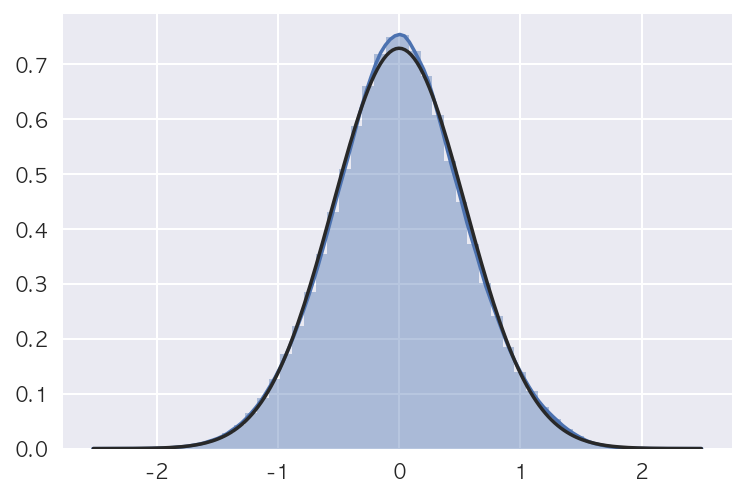

In [30]:
sns.distplot(result_04.resid, fit=sp.stats.norm)

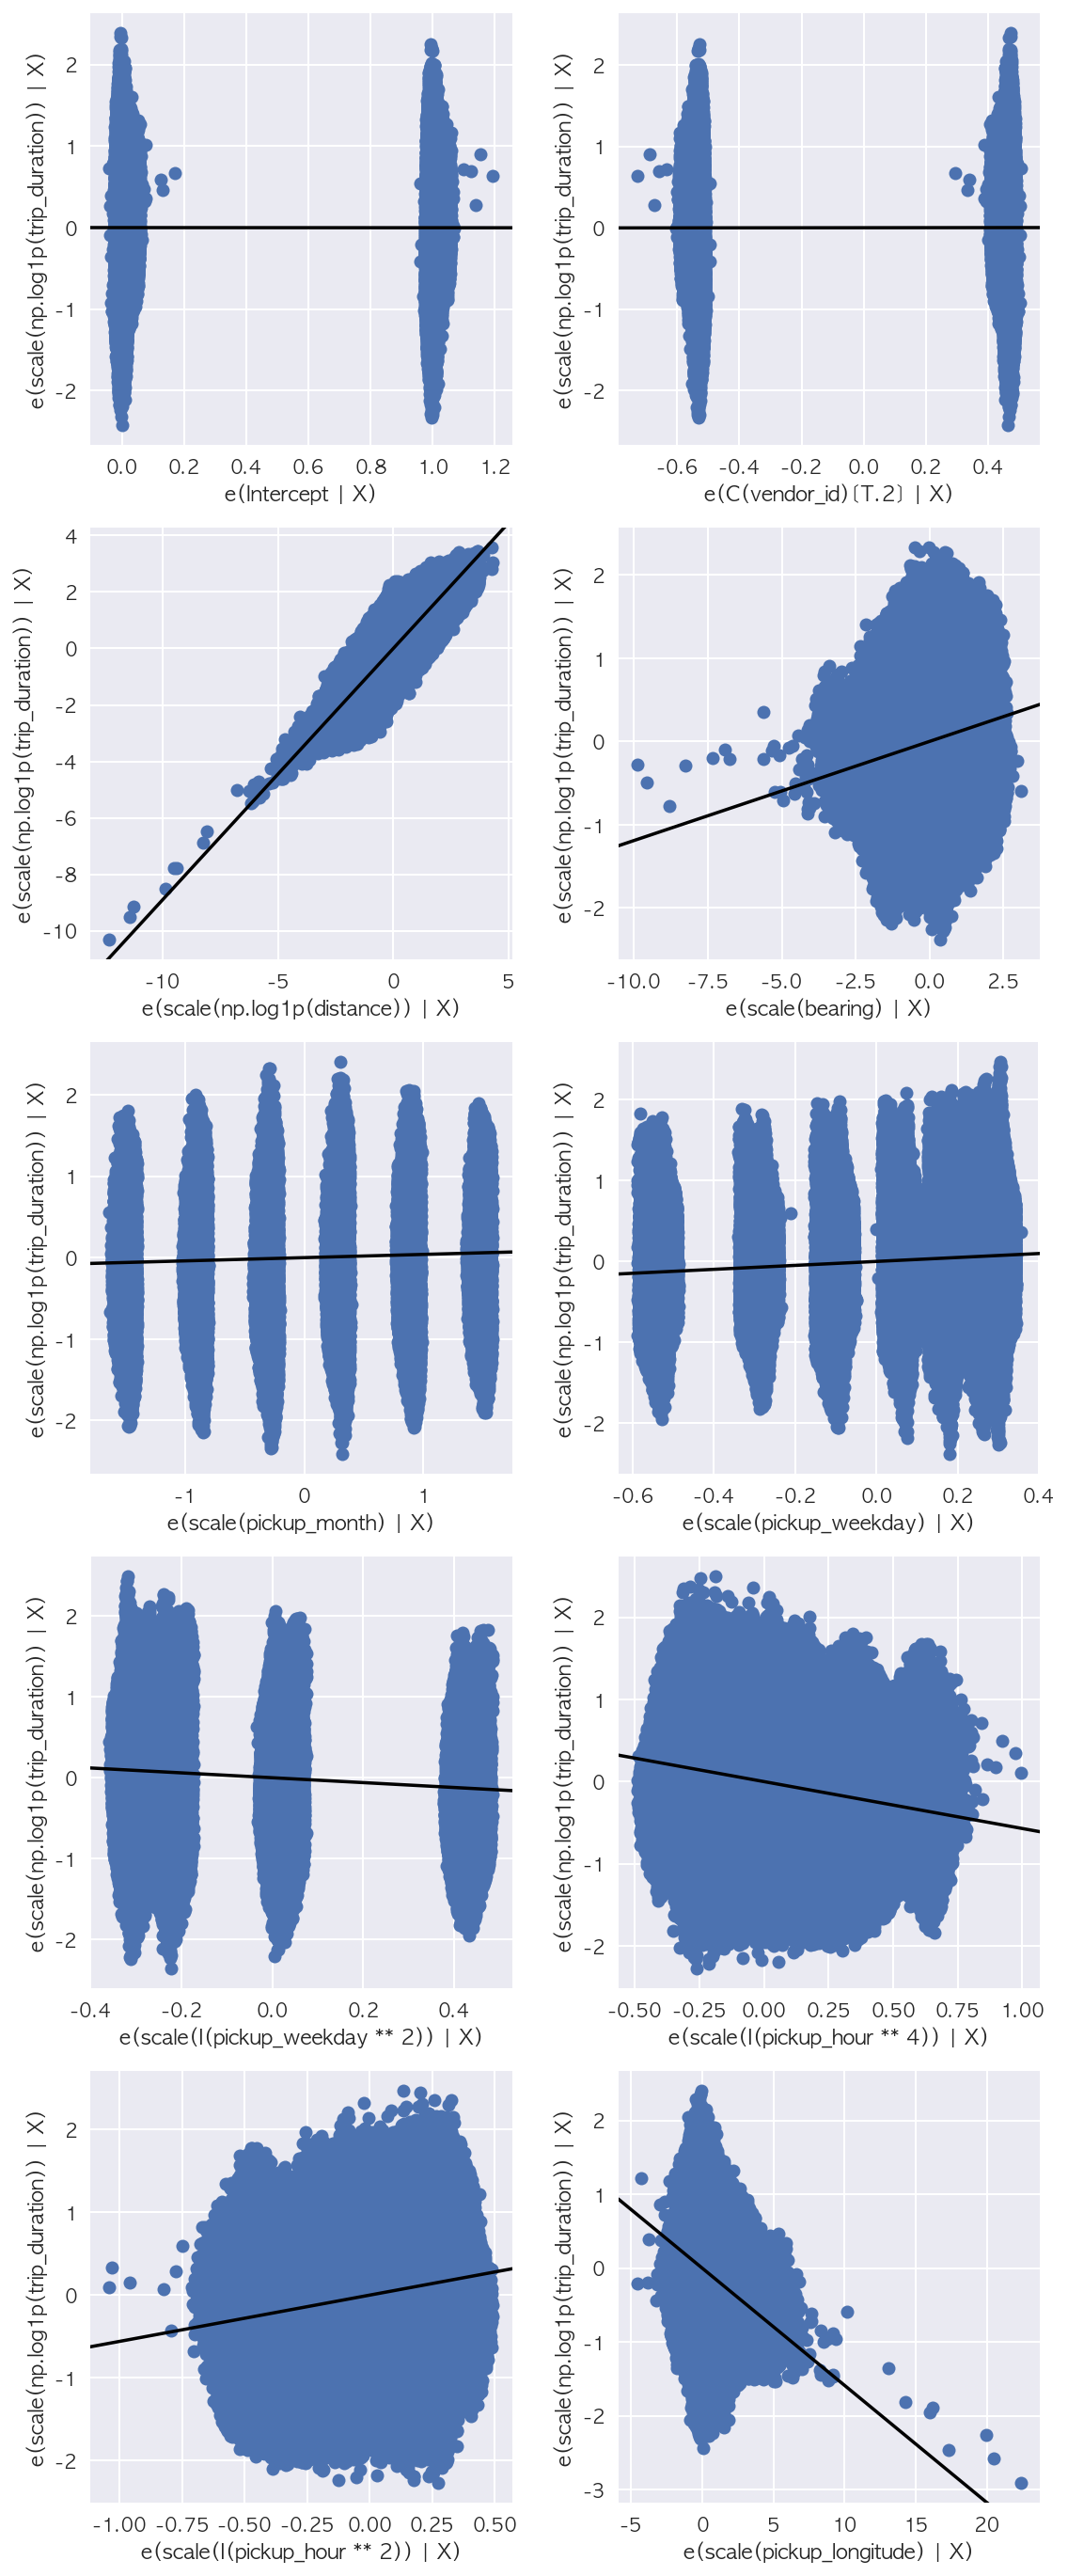

In [31]:
fig = plt.figure(figsize=(8,20))
sm.graphics.plot_partregress_grid(result_04, fig=fig)
fig.suptitle("")
plt.show()

In [ ]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)

    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)

    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    # difference = (log_predict - log_actual) ** 2
    difference = np.square(difference)

    # 평균을 낸다.
    mean_difference = difference.mean()

    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)

    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

In [ ]:
model = sm.OLS.from_formula("scale(np.log1p(trip_duration)) ~ scale(np.log1p(distance)) + scale(bearing) + scale(pickup_month) +" 
                            "scale(pickup_weekday) + scale(I(pickup_weekday**2)) + scale(I(pickup_hour**4))+"
                            "scale(I(pickup_hour**2))+ scale(pickup_longitude) +"
                            "+ C(vendor_id)" , train_out)
result_dummy = model.fit()
print(result_dummy.summary())

In [ ]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X, y, coef = make_regression(n_samples=1000, n_features=1, noise=20, coef=True, random_state=0)

model = LinearRegression()
cv = KFold(10)

scores = np.zeros(10)
for i, (train_index, test_index) in enumerate(cv.split(X)):
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores[i] = r2_score(y_test, y_pred)

scores

In [74]:
train_cooks.drop(idx_cooks, inplace=True)
# train_cooks.reset_index(drop=True, inplace=True)
len(train_cooks), len(train)

(1349101, 1456739)

In [75]:
model = sm.OLS.from_formula("scale(np.log1p(trip_duration)) ~ scale(np.log1p(distance)) + scale(bearing) + scale(pickup_month) +" 
                            "scale(pickup_weekday) + scale(pickup_hour) + scale(pickup_longitude) +"
                            "scale(dropoff_longitude) + C(vendor_id)" , train_cooks)
result_04 = model.fit()
print(result_04.summary())

                                  OLS Regression Results                                  
Dep. Variable:     scale(np.log1p(trip_duration))   R-squared:                       0.678
Model:                                        OLS   Adj. R-squared:                  0.678
Method:                             Least Squares   F-statistic:                 3.544e+05
Date:                            Wed, 14 Mar 2018   Prob (F-statistic):               0.00
Time:                                    11:15:35   Log-Likelihood:            -1.1507e+06
No. Observations:                         1349101   AIC:                         2.302e+06
Df Residuals:                             1349092   BIC:                         2.302e+06
Df Model:                                       8                                         
Covariance Type:                        nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.9

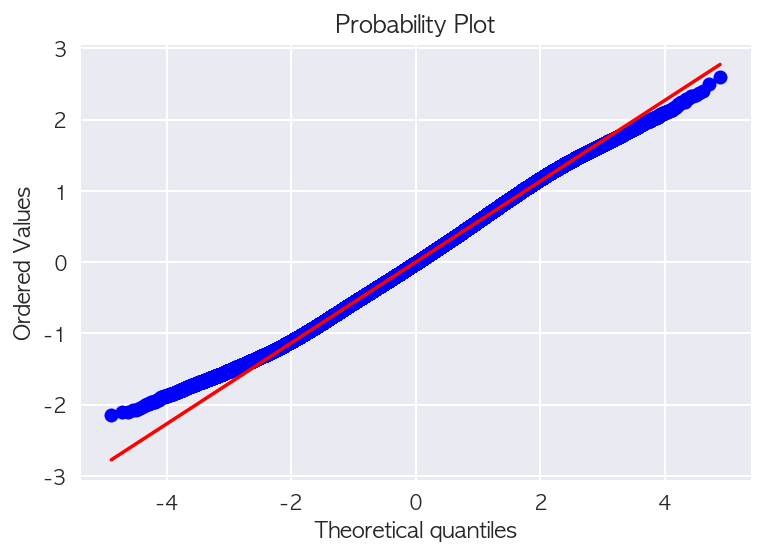

In [76]:
sp.stats.probplot(result_04.resid, plot=plt)
plt.show()

In [92]:
model = sm.OLS.from_formula("scale(np.log1p(trip_duration)) ~ scale(np.log1p(distance)) + scale(bearing) + scale(pickup_month) +" 
                            "scale(pickup_weekday) + scale(I(pickup_weekday**2)) + scale(I(pickup_hour**4))+"
                            "scale(I(pickup_hour**2))+ scale(pickup_longitude) +"
                            "+ C(vendor_id)" , train_cooks)
result_04 = model.fit()
print(result_04.summary())

                                  OLS Regression Results                                  
Dep. Variable:     scale(np.log1p(trip_duration))   R-squared:                       0.704
Model:                                        OLS   Adj. R-squared:                  0.703
Method:                             Least Squares   F-statistic:                 3.557e+05
Date:                            Wed, 14 Mar 2018   Prob (F-statistic):               0.00
Time:                                    11:48:50   Log-Likelihood:            -1.0942e+06
No. Observations:                         1349101   AIC:                         2.188e+06
Df Residuals:                             1349091   BIC:                         2.189e+06
Df Model:                                       9                                         
Covariance Type:                        nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025     

In [82]:
train_vif = train[["distance", "bearing", "pickup_month", "pickup_weekday", "pickup_hour", "pickup_longitude", "dropoff_longitude"]]

In [84]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(train_vif.values, i) for i in range(train_vif.shape[1])]
vif["features"] = train_vif.columns
vif

,VIF Factor,features
0,1.754994e+00,distance
1,4.049606e+00,bearing
2,5.379341e+00,pickup_month
3,3.463378e+00,pickup_weekday
4,5.578120e+00,pickup_hour
5,3.362297e+06,pickup_longitude
6,3.366045e+06,dropoff_longitude


((array([-4.88628414, -4.70859894, -4.6125953 , ...,  4.6125953 ,
          4.70859894,  4.88628414]),
  array([-2.3473804 , -2.3289108 , -2.30264625, ...,  2.19667732,
          2.34969863,  2.35400127])),
 (0.54445772578566498, -4.478497805839965e-16, 0.99988684438199871))

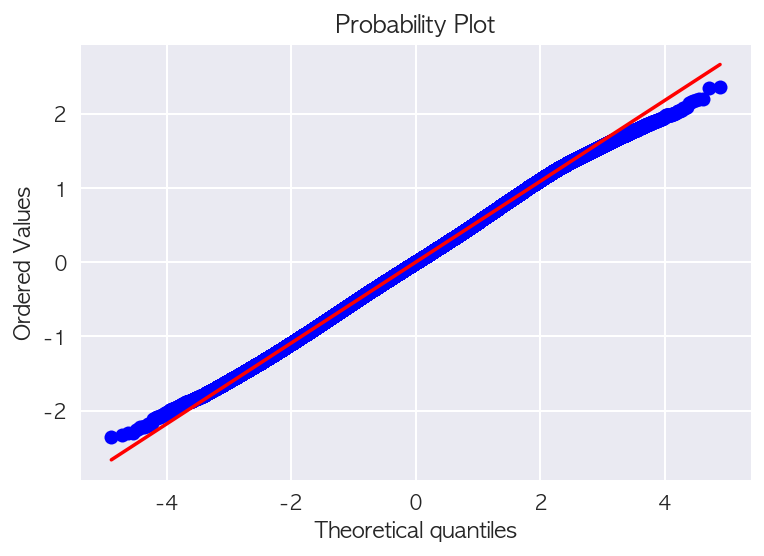

In [95]:
sp.stats.probplot(result_04.resid, plot=plt)

In [100]:
hat = result_04.get_influence().hat_matrix_diag
idx = np.where(hat > 3*hat.mean())[0]

In [ ]:
idx_rp = np.where(result_04.resid_pearson > 3)[0]

In [112]:
train_hat = train_cooks.copy()

In [113]:
train_hat.reset_index(drop=True, inplace=True)

In [105]:
train_hat = train_ft.drop(idx)
train_hat.reset_index(drop=True, inplace=True)

In [107]:
len(train_ft)

1324447

In [110]:
model = sm.OLS.from_formula("scale(np.log1p(trip_duration)) ~ scale(np.log1p(distance)) + scale(bearing) + scale(pickup_month) +" 
                            "scale(pickup_weekday) + scale(I(pickup_weekday**2)) + scale(I(pickup_hour**4))+"
                            "scale(I(pickup_hour**2))+ scale(pickup_longitude) +"
                            "+ C(vendor_id)" , train_ft)
result_05 = model.fit()
print(result_05.summary())

                                  OLS Regression Results                                  
Dep. Variable:     scale(np.log1p(trip_duration))   R-squared:                       0.683
Model:                                        OLS   Adj. R-squared:                  0.683
Method:                             Least Squares   F-statistic:                 3.172e+05
Date:                            Wed, 14 Mar 2018   Prob (F-statistic):               0.00
Time:                                    13:12:56   Log-Likelihood:            -1.1183e+06
No. Observations:                         1324447   AIC:                         2.237e+06
Df Residuals:                             1324437   BIC:                         2.237e+06
Df Model:                                       9                                         
Covariance Type:                        nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025     

((array([-4.88264984, -4.70483751, -4.60876153, ...,  4.60876153,
          4.70483751,  4.88264984]),
  array([-2.41823205, -2.39807829, -2.3746417 , ...,  2.26262021,
          2.41415833,  2.41792962])),
 (0.56286594441161852, 1.6903598145995944e-16, 0.99988679497757493))

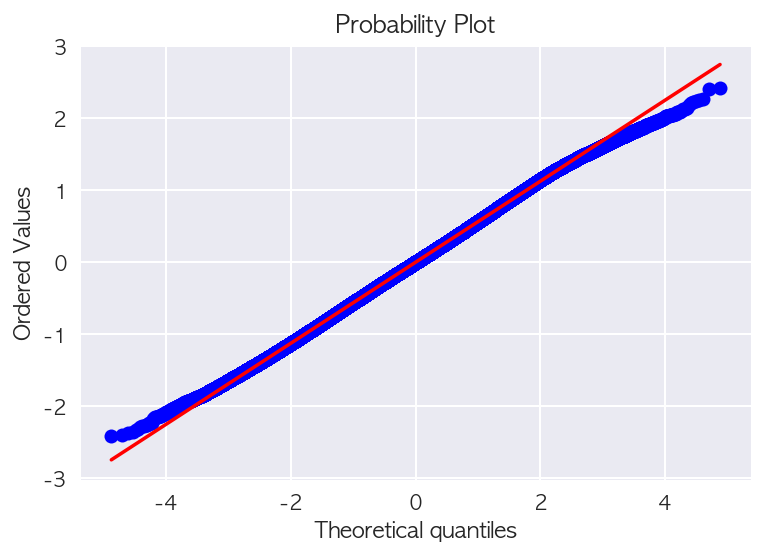

In [111]:
sp.stats.probplot(result_05.resid, plot=plt)

In [97]:
influence = result_04.get_influence()
cooks_d2, pvals = influence.cooks_distance
fox_cr = 4 / (len(train) - 10)
len(np.where(cooks_d2 > fox_cr)[0])
# idx_cooks = np.where(cooks_d2 > fox_cr)[0]
# train_cooks = train.drop(idx_cooks)
# train_cooks.reset_index(drop=True, inplace=True)
# len(train_cooks), len(train)

67862

In [ ]:
train_ft = train_cooks

In [ ]:
col_reals = col_real + ["pickup_hour", "pickup_weekday", "pickup_month"]
train_reals = train[col_reals]

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(train_reals.values, i) for i in range(train_reals.shape[1])]
vif["features"] = train_reals.columns
vif

In [67]:
result_sets = pd.DataFrame(columns=["R_squared", "Adj.R_squared", "AIC", "BIC", "P_fstatics", 
                                    "P_omnibus", "P_jb", "Cond_no", "changed"])

In [68]:
# 수정본 (Team B-5)
# 전역변수로 result_sets을 선언하고 사용

def storage(result, change) :
    
    summary = result.summary()
    table = summary.tables[2]
    
    p_omnibus = float(table.data[1][1])
    p_jb = float(table.data[2][3])
    
    put = {
        "R_squared" : result.rsquared,
        "Adj.R_squared": result.rsquared_adj,
        "AIC" : result.aic,
        "BIC" : result.bic,
        "P_fstatics" : result.f_pvalue,
        "P_omnibus" : p_omnibus,
        "P_jb" : p_jb,
        "Cond_no" : result.condition_number, 
        "changed" : change,
    }
    
    result_sets.loc[len(result_sets)] = put

## poly10

In [16]:
model = sm.OLS.from_formula("np.log1p(trip_duration) ~ np.log1p(distance) +" 
                            "scale(I(pickup_hour**2)) + scale(I(pickup_hour**4))+"
                            "scale(dropoff_latitude) + C(working_day)", train)
result = model.fit()
print(result.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.589
Model:                                 OLS   Adj. R-squared:                  0.589
Method:                      Least Squares   F-statistic:                 4.174e+05
Date:                     Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                             16:28:45   Log-Likelihood:            -1.0887e+06
No. Observations:                  1458644   AIC:                         2.177e+06
Df Residuals:                      1458638   BIC:                         2.177e+06
Df Model:                                5                                         
Covariance Type:                 nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

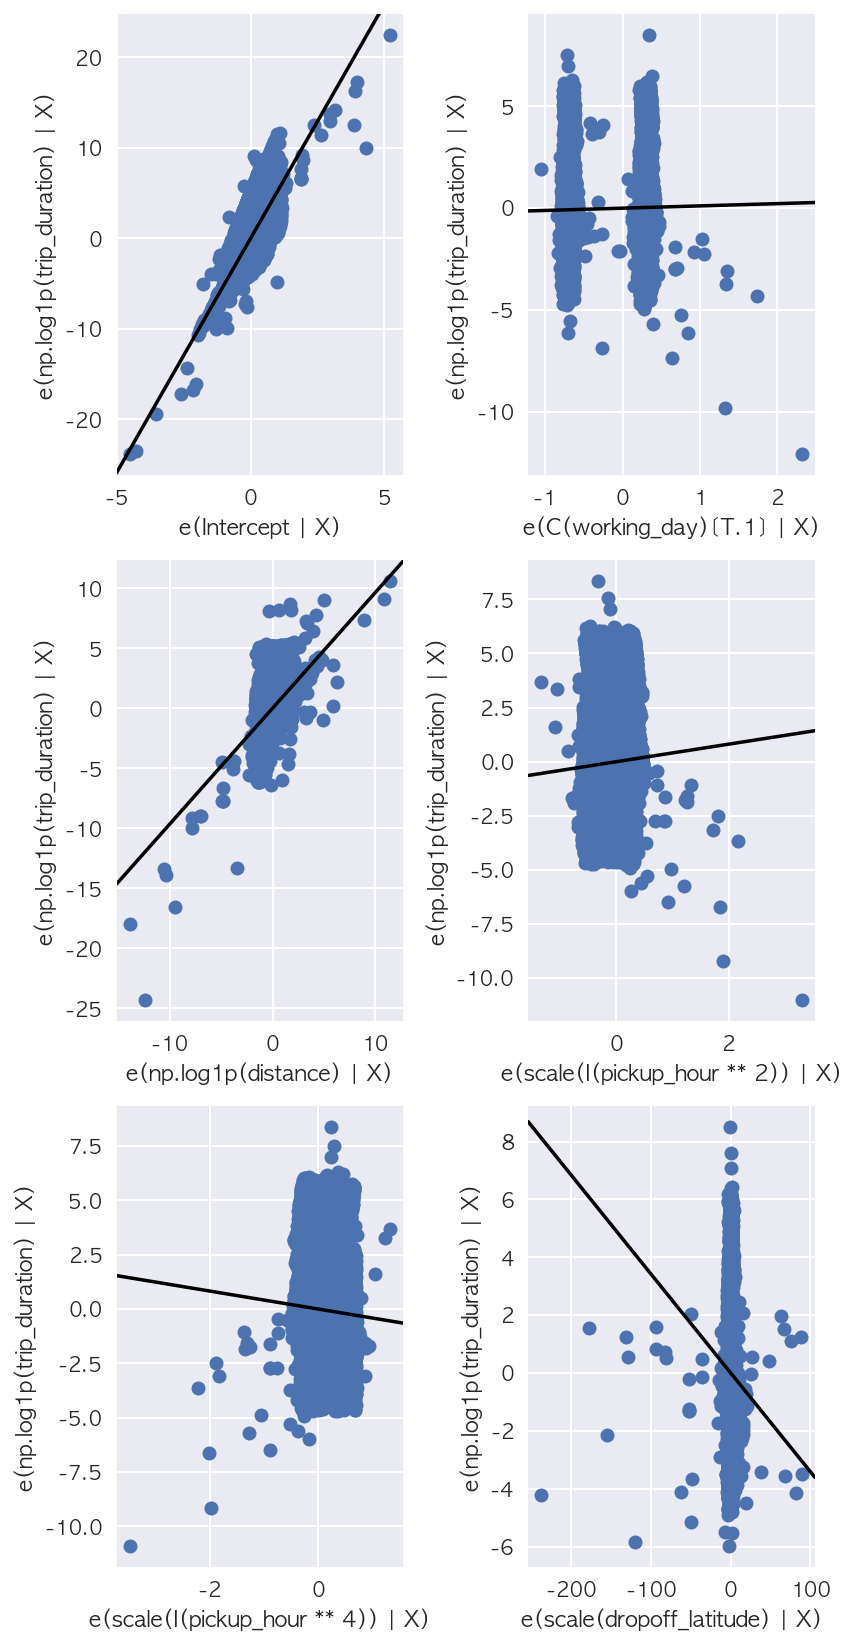

In [17]:
fig = plt.figure(figsize=(6, 12))
sm.graphics.plot_partregress_grid(result, fig=fig)
fig.suptitle("")
plt.show()

In [18]:
influence = result.get_influence()
hat = influence.hat_matrix_diag

In [19]:
# plt.figure(figsize=(10, 2))
# plt.stem(hat[::1000])
# plt.show()

In [20]:
idx = np.where(hat > 3 * hat.mean())[0]
len(idx)

26544

In [21]:
train_out_01 = train.copy()

In [22]:
len(train), len(train_out_01.drop(idx))

(1458644, 1432100)

In [23]:
train_out_01.drop(idx, inplace=True)

In [24]:
train_out_01.reset_index(drop=True, inplace=True)

In [25]:
storage(result, "poly10")

In [26]:
result_sets

,R_squared,Adj.R_squared,AIC,BIC,P_fstatics,P_omnibus,P_jb,Cond_no,changed
0,0.588629,0.588627,2.177331e+06,2.177404e+06,0.0,0.0,0.0,9.404033,poly10


## 2. outlier 제거 (레버리지 평균의 3배)

In [27]:
model = sm.OLS.from_formula("np.log1p(trip_duration) ~ np.log1p(distance) +" 
                            "scale(I(pickup_hour**2)) + scale(I(pickup_hour**4))+"
                            "scale(dropoff_latitude) + C(working_day)", train_out_01)
result_02 = model.fit()
print(result_02.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.580
Model:                                 OLS   Adj. R-squared:                  0.580
Method:                      Least Squares   F-statistic:                 3.962e+05
Date:                     Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                             16:30:05   Log-Likelihood:            -1.0560e+06
No. Observations:                  1432100   AIC:                         2.112e+06
Df Residuals:                      1432094   BIC:                         2.112e+06
Df Model:                                5                                         
Covariance Type:                 nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [28]:
storage(result_02, "레버리지 평균 3배 이상 제거")

In [29]:
result_sets

,R_squared,Adj.R_squared,AIC,BIC,P_fstatics,P_omnibus,P_jb,Cond_no,changed
0,0.588629,0.588627,2.177331e+06,2.177404e+06,0.0,0.0,0.0,9.404033,poly10
1,0.580441,0.580439,2.111924e+06,2.111997e+06,0.0,0.0,0.0,9.293296,레버리지 평균 3배 이상 제거


In [30]:
# fig = plt.figure(figsize=(8, 14))
# sm.graphics.plot_partregress_grid(result_02, fig=fig)
# fig.suptitle("")
# plt.show()

In [31]:
influence = result_02.get_influence()
hat = influence.hat_matrix_diag

In [32]:
# plt.figure(figsize=(10, 2))
# plt.stem(hat[::1000])
# plt.show()

In [33]:
idx = np.where(hat > 3 * hat.mean())[0]
len(idx)

18357

In [34]:
train_out_02 = train_out_01.copy()

In [35]:
train_out_02.drop(idx, inplace=True)

In [36]:
train_out_02.reset_index(drop=True, inplace=True)

## 3. 2의 레버리지 3배 이상 제거

In [38]:
model = sm.OLS.from_formula("np.log1p(trip_duration) ~ np.log1p(distance) +" 
                            "scale(I(pickup_hour**2)) + scale(I(pickup_hour**4))+"
                            "scale(dropoff_latitude) + C(working_day)", train_out_02)
result_03 = model.fit()
print(result_03.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.579
Model:                                 OLS   Adj. R-squared:                  0.579
Method:                      Least Squares   F-statistic:                 3.882e+05
Date:                     Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                             15:05:12   Log-Likelihood:            -1.0294e+06
No. Observations:                  1413743   AIC:                         2.059e+06
Df Residuals:                      1413737   BIC:                         2.059e+06
Df Model:                                5                                         
Covariance Type:                 nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [39]:
storage(result_03, "2의 레버리지 3배 이상 제거")

In [40]:
result_sets

,R_squared,Adj.R_squared,AIC,BIC,P_fstatics,P_omnibus,P_jb,Cond_no,changed
0,0.588629,0.588627,2.177331e+06,2.177404e+06,0.0,0.0,0.0,9.404033,poly10
1,0.580441,0.580439,2.111924e+06,2.111997e+06,0.0,0.0,0.0,9.293296,레버리지 평균 3배 이상 제거
2,0.578570,0.578569,2.058747e+06,2.058820e+06,0.0,0.0,0.0,9.227337,2의 레버리지 3배 이상 제거


In [41]:
y = train_out_02.loc[:, ["trip_duration"]]
x = train_out_02.loc[:, ["distance"]]

In [ ]:
model = sm.OLS.from_formula("np.log1p(trip_duration) ~ np.log1p(distance) +" 
                            "abs(np.sin(pickup_hour)) +"
                            "scale(dropoff_latitude) + C(working_day)", train)
result_02 = model.fit()
print(result_02.summary())

In [ ]:
fig = plt.figure(figsize=(8, 20))
sm.graphics.plot_partregress_grid(result_02, fig=fig)
fig.suptitle("")
plt.show()

In [43]:
model = sm.OLS.from_formula("np.log1p(trip_duration) ~ np.log1p(distance) +" 
                            "scale(I(pickup_hour**2)) + scale(I(pickup_hour**4))+"
                            "scale(dropoff_latitude) + working_day", train_out_01)
result_03 = model.fit()
print(result_03.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.580
Model:                                 OLS   Adj. R-squared:                  0.580
Method:                      Least Squares   F-statistic:                 3.962e+05
Date:                     Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                             15:06:53   Log-Likelihood:            -1.0560e+06
No. Observations:                  1432100   AIC:                         2.112e+06
Df Residuals:                      1432094   BIC:                         2.112e+06
Df Model:                                5                                         
Covariance Type:                 nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [37]:
train_out_01 = train_out_01[train_out_01["trip_duration"] < 150000]

In [38]:
model = sm.OLS.from_formula("scale(trip_duration) ~ scale(distance) +" 
                            "scale(I(pickup_hour**2)) + scale(I(pickup_hour**4))+"
                            "+ scale(bearing) + C(working_day) + pickup_month", train_out_01)
result_04 = model.fit()
print(result_04.summary())

                             OLS Regression Results                             
Dep. Variable:     scale(trip_duration)   R-squared:                       0.025
Model:                              OLS   Adj. R-squared:                  0.025
Method:                   Least Squares   F-statistic:                     6100.
Date:                  Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                          16:31:33   Log-Likelihood:            -2.0140e+06
No. Observations:               1432096   AIC:                         4.028e+06
Df Residuals:                   1432089   BIC:                         4.028e+06
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------


In [39]:
influence = result_04.get_influence()
hat = influence.hat_matrix_diag

In [42]:
idx = np.where(hat > 3*hat.mean())[0]
train_out_01.drop(idx, inplace=True)
train_out_01.reset_index(drop=True, inplace=True)

In [43]:
train_out_01.shape[0]

1406918

In [44]:
model = sm.OLS.from_formula("scale(trip_duration) ~ scale(distance) +" 
                            "scale(pickup_hour) + scale(I(pickup_hour**2)) + scale(I(pickup_hour**4))+"
                            "+ scale(bearing) + C(working_day) + pickup_month", train_out_01)
result_05 = model.fit()
print(result_05.summary())

                             OLS Regression Results                             
Dep. Variable:     scale(trip_duration)   R-squared:                       0.023
Model:                              OLS   Adj. R-squared:                  0.023
Method:                   Least Squares   F-statistic:                     4799.
Date:                  Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                          16:33:07   Log-Likelihood:            -1.9797e+06
No. Observations:               1406918   AIC:                         3.959e+06
Df Residuals:                   1406910   BIC:                         3.960e+06
Df Model:                             7                                         
Covariance Type:              nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------


In [45]:
influence = result_05.get_influence()
cooks_d2, pvals = influence.cooks_distance
fox_cr = 4 / (len(train) - 2)
idx = np.where(cooks_d2 > fox_cr)[0]

In [46]:
train_out_01.drop(idx, inplace=True)
train_out_01.reset_index(drop=True, inplace=True)
len(train_out_01)

1404731

In [47]:
model = sm.OLS.from_formula("np.log1p(trip_duration) ~ np.log1p(distance) +" 
                            "scale(I(pickup_hour**2)) + scale(I(pickup_hour**4))+"
                            "scale(dropoff_latitude) + working_day", train_out_01)
result_06 = model.fit()
print(result_06.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.609
Model:                                 OLS   Adj. R-squared:                  0.609
Method:                      Least Squares   F-statistic:                 4.381e+05
Date:                     Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                             16:33:44   Log-Likelihood:            -9.3787e+05
No. Observations:                  1404731   AIC:                         1.876e+06
Df Residuals:                      1404725   BIC:                         1.876e+06
Df Model:                                5                                         
Covariance Type:                 nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [48]:
idx = np.where(result_06.resid_pearson > 2)[0]

In [49]:
train_out_01.drop(idx, inplace=True)
train_out_01.reset_index(drop=True, inplace=True)

In [50]:
len(train_out_01)

1378031

In [51]:
model = sm.OLS.from_formula("np.log1p(trip_duration) ~ np.log1p(distance) +" 
                            "scale(I(pickup_hour**2)) + scale(I(pickup_hour**4))+"
                            "scale(dropoff_latitude) + working_day", train_out_01)
result_07 = model.fit()
print(result_07.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.657
Model:                                 OLS   Adj. R-squared:                  0.657
Method:                      Least Squares   F-statistic:                 5.284e+05
Date:                     Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                             16:34:33   Log-Likelihood:            -8.2220e+05
No. Observations:                  1378031   AIC:                         1.644e+06
Df Residuals:                      1378025   BIC:                         1.644e+06
Df Model:                                5                                         
Covariance Type:                 nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [53]:
hat = result_07.get_influence().hat_matrix_diag

In [58]:
idx = np.where(hat > 2 * hat.mean())[0]
len(idx)

101371

In [59]:
train_out_01.drop(idx, inplace=True)
train_out_01.reset_index(drop=True, inplace=True)
len(train_out_01)

1276660

In [66]:
model = sm.OLS.from_formula("scale(trip_duration) ~ scale(distance) + scale(I(distance**2))+" 
                            "scale(I(pickup_hour**2)) + scale(I(pickup_hour**4))+"
                            "scale(dropoff_latitude) + working_day", train_out_01)
result_08 = model.fit()
print(result_08.summary())

                             OLS Regression Results                             
Dep. Variable:     scale(trip_duration)   R-squared:                       0.651
Model:                              OLS   Adj. R-squared:                  0.651
Method:                   Least Squares   F-statistic:                 3.965e+05
Date:                  Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                          16:42:18   Log-Likelihood:            -1.1400e+06
No. Observations:               1276660   AIC:                         2.280e+06
Df Residuals:                   1276653   BIC:                         2.280e+06
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------


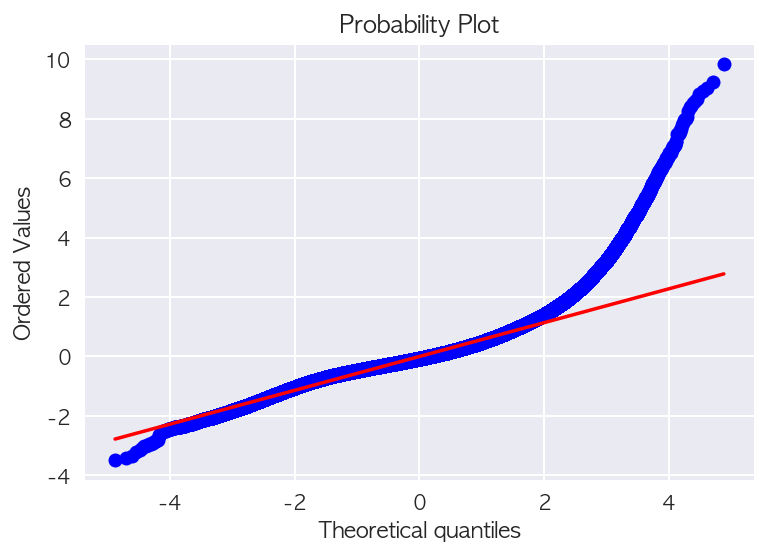

In [67]:
sp.stats.probplot(result_08.resid, plot=plt)
plt.show()

In [69]:
idx = np.where(result_08.resid_pearson > 2)[0]
len(idx)

46402

In [70]:
train_out_01.drop(idx, inplace=True)
train_out_01.reset_index(drop=True, inplace=True)
len(train_out_01)

1230258

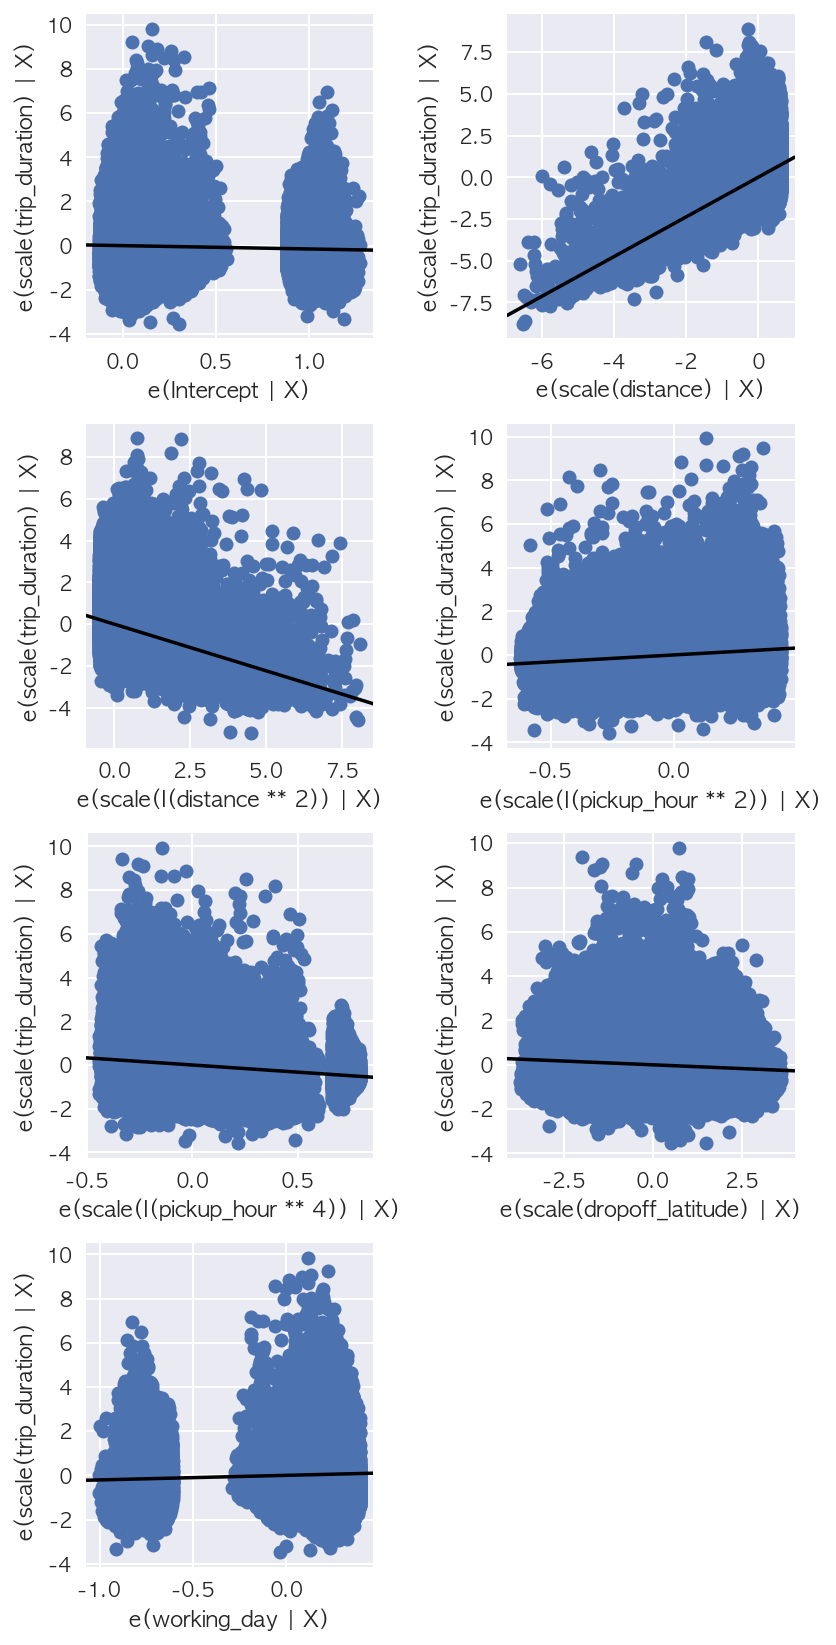

In [68]:
fig = plt.figure(figsize=(6, 12))
sm.graphics.plot_partregress_grid(result_08, fig=fig)
fig.suptitle("")
plt.show()

In [71]:
model = sm.OLS.from_formula("scale(trip_duration) ~ scale(distance) + scale(I(distance**2))+" 
                            "scale(I(pickup_hour**2)) + scale(I(pickup_hour**4))+"
                            "scale(dropoff_latitude) + working_day", train_out_01)
result_09 = model.fit()
print(result_09.summary())

                             OLS Regression Results                             
Dep. Variable:     scale(trip_duration)   R-squared:                       0.686
Model:                              OLS   Adj. R-squared:                  0.686
Method:                   Least Squares   F-statistic:                 4.483e+05
Date:                  Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                          16:47:05   Log-Likelihood:            -1.0328e+06
No. Observations:               1230258   AIC:                         2.066e+06
Df Residuals:                   1230251   BIC:                         2.066e+06
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------


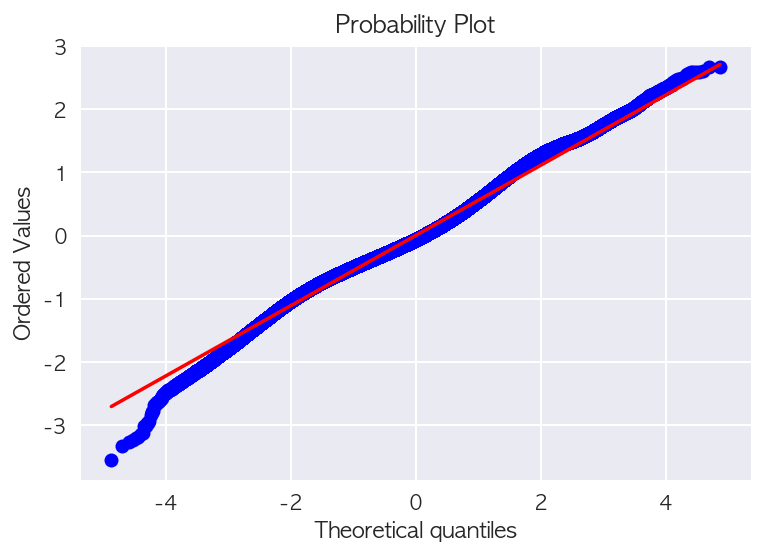

In [72]:
sp.stats.probplot(result_09.resid, plot=plt)
plt.show()

In [75]:
model = sm.OLS.from_formula("scale(trip_duration) ~ scale(distance) + scale(I(distance**2))+" 
                            "scale(I(pickup_hour**2)) + scale(I(pickup_hour**4))+"
                            "scale(dropoff_latitude) + working_day", train_out_01)
result_10 = model.fit()
print(result_10.summary())

                             OLS Regression Results                             
Dep. Variable:     scale(trip_duration)   R-squared:                       0.690
Model:                              OLS   Adj. R-squared:                  0.690
Method:                   Least Squares   F-statistic:                 3.906e+05
Date:                  Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                          16:50:59   Log-Likelihood:            -1.0258e+06
No. Observations:               1230258   AIC:                         2.052e+06
Df Residuals:                   1230250   BIC:                         2.052e+06
Df Model:                             7                                         
Covariance Type:              nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------


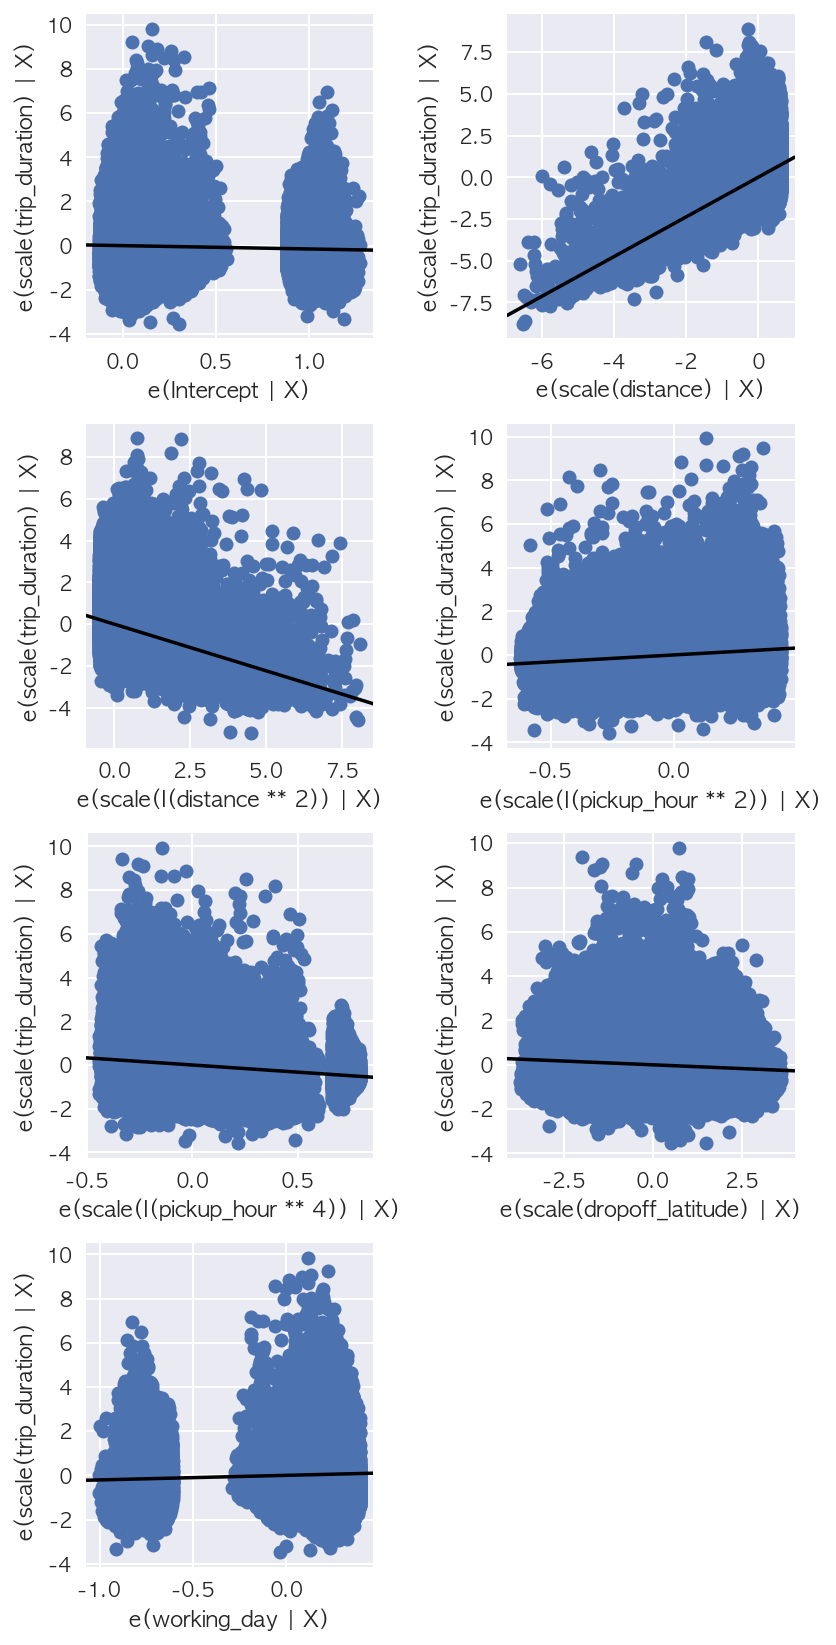

In [77]:
fig = plt.figure(figsize=(6, 12))
sm.graphics.plot_partregress_grid(result_08, fig=fig)
fig.suptitle("")
plt.show()

In [90]:
model = sm.OLS.from_formula("scale(trip_duration) ~ scale(distance) + scale(I(distance**2))+" 
                            "scale(np.exp(bearing)) + scale(I(pickup_hour**2)) + scale(I(pickup_hour**4))+"
                            "scale(dropoff_latitude) + working_day", train_out_01)
result_11 = model.fit()
print(result_11.summary())

                             OLS Regression Results                             
Dep. Variable:     scale(trip_duration)   R-squared:                       0.686
Model:                              OLS   Adj. R-squared:                  0.686
Method:                   Least Squares   F-statistic:                 3.844e+05
Date:                  Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                          17:01:41   Log-Likelihood:            -1.0327e+06
No. Observations:               1230258   AIC:                         2.065e+06
Df Residuals:                   1230250   BIC:                         2.065e+06
Df Model:                             7                                         
Covariance Type:              nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------


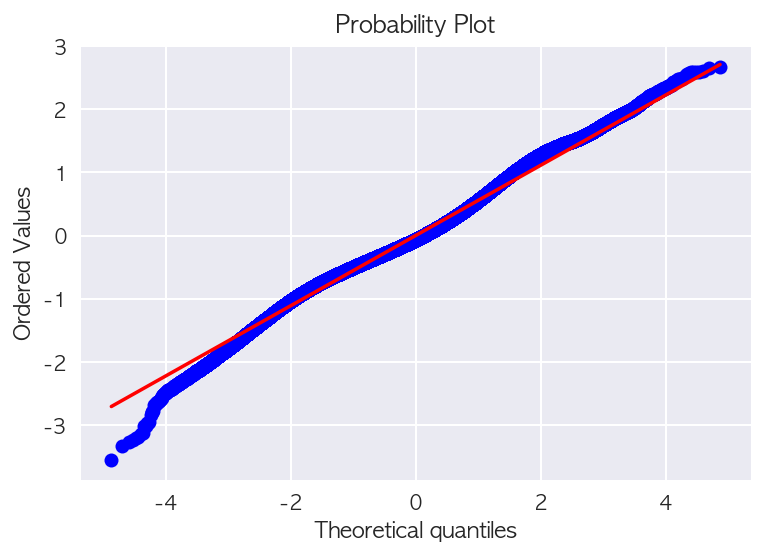

In [91]:
sp.stats.probplot(result_11.resid, plot=plt)
plt.show()

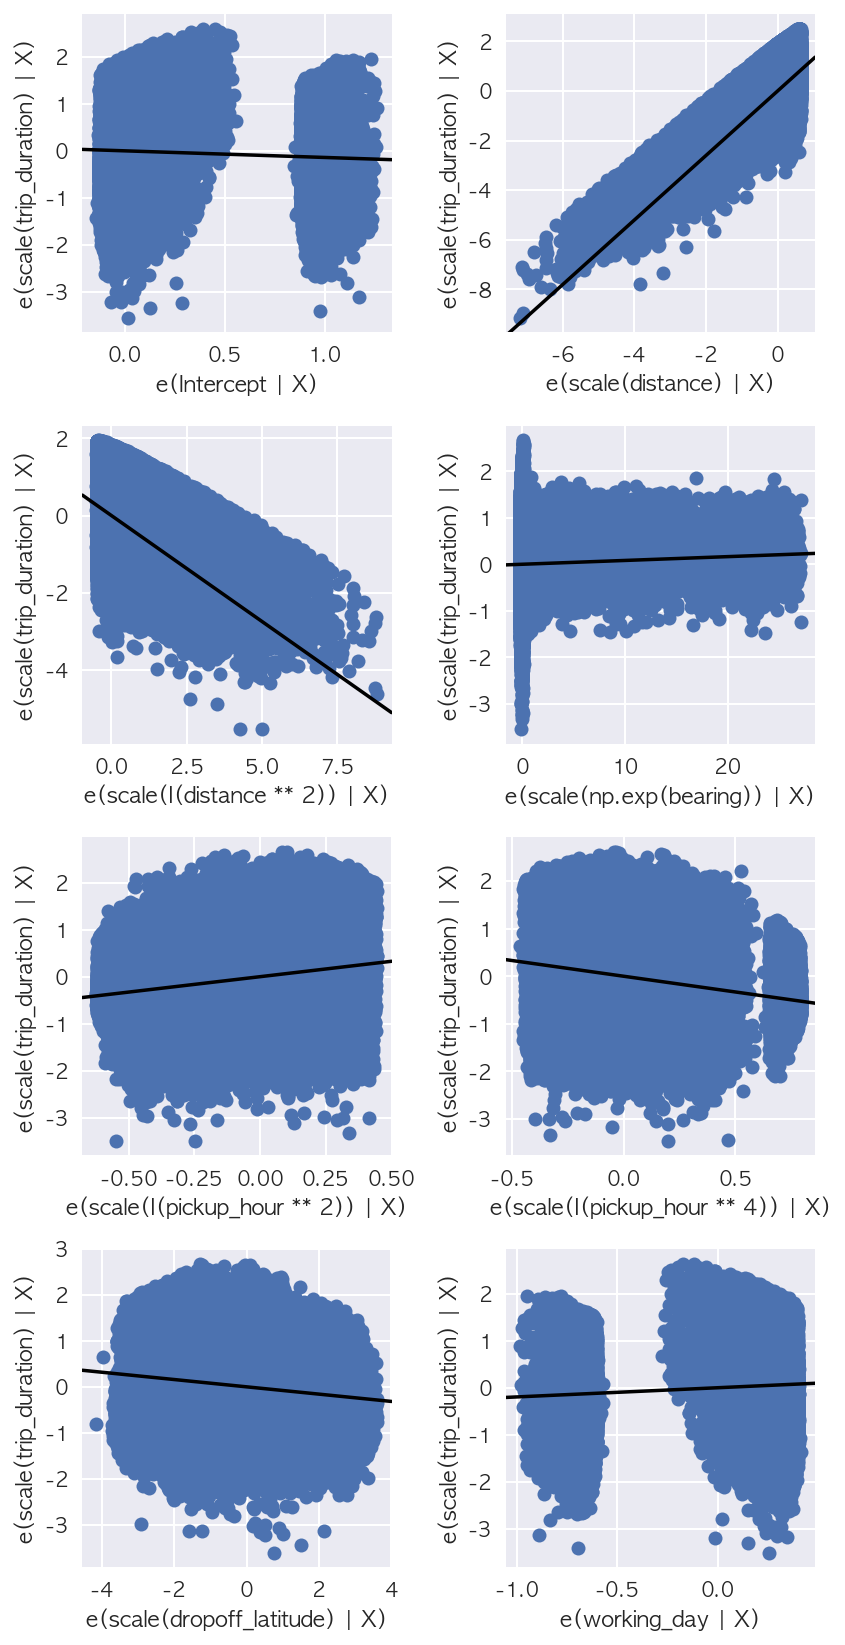

In [149]:
fig = plt.figure(figsize=(6, 12))
sm.graphics.plot_partregress_grid(result_11, fig=fig)
fig.suptitle("")
plt.show()

In [ ]:
cooks_d2, pvals = influence.cooks_distance
fox_cr = 4 / (len(y) - 2)
idx = np.where(cooks_d2 > fox_cr)[0]

plt.figure(figsize=(8, 5))
ax = plt.subplot()
plt.scatter(y, y_hat)
plt.scatter(y[idx], y_hat[idx], s=300, c="r", alpha=0.5)
utils.annotate_axes(range(len(idx)), idx, 
                    list(zip(y[idx], y_hat[idx])), [(-20, 15)] * len(idx), size="small", ax=ax)
plt.show()